In [222]:
import numpy as np
np.random.seed(100)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pysensors as ps

# Data Generation

In [223]:
def generate_simple_flow(n_timesteps, nx, ny):
    # create a moving Gaussian "blob" that travels across the domain.
    data = np.zeros((n_timesteps, nx, ny))
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')

    for t in range(n_timesteps):
        # The center of the blob moves linearly through the domain.
        cx = 0.8 - 0.6 * (t / n_timesteps)
        cy = 0.2 + 0.6 * (t / n_timesteps)
        data[t] = np.exp(-((Xgrid - cx)**2 + (Ygrid - cy)**2) / 0.01)

    return data

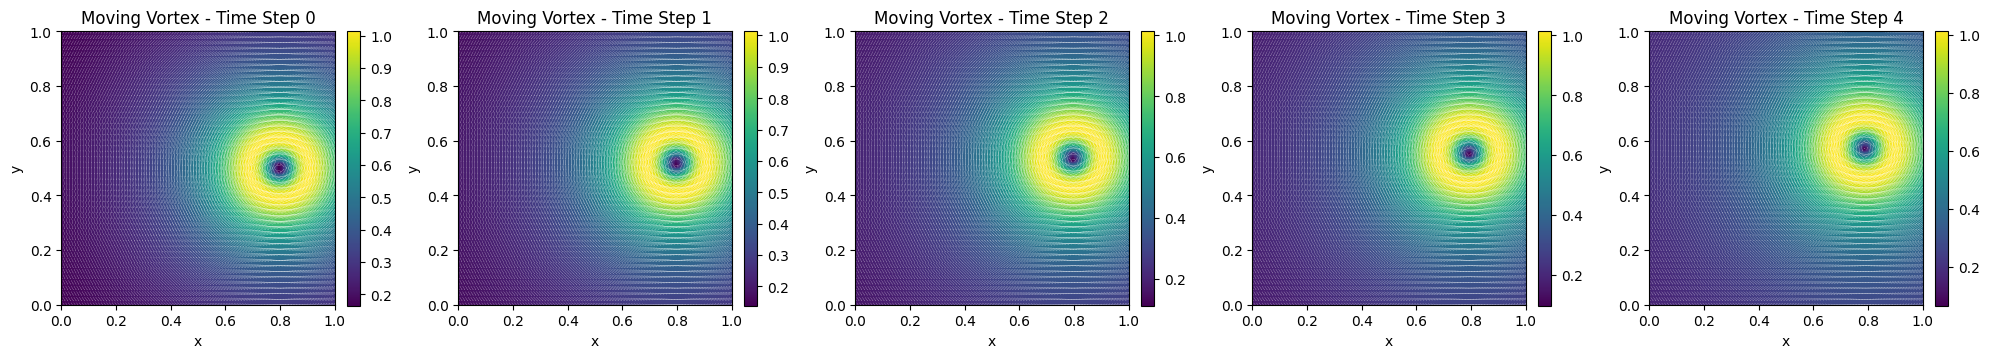

In [224]:
def generate_moving_vortex(n_timesteps, nx, ny, plot_series=False, plot_interval=1):
    """
    Generate a moving vortex flow field based on the Lamb–Oseen vortex solution.
    The instantaneous velocity field is computed as:
    
        u(x,y,t) = - (Gamma/(2π)) * ( (y - y0(t)) / r² ) * [1 - exp(-r²/r_c²)]
        v(x,y,t) =   (Gamma/(2π)) * ( (x - x0(t)) / r² ) * [1 - exp(-r²/r_c²)]
        
    where r² = (x - x0(t))² + (y - y0(t))².
    """
    # Vortex parameters
    Gamma = 1.0
    r_c = 0.1
    x_center = 0.5
    y_center = 0.5
    r_move = 0.3  # amplitude of the center's circular motion
    cycle_length = 100

    data = np.zeros((n_timesteps, nx, ny))
    u_field = np.zeros((n_timesteps, nx, ny))
    v_field = np.zeros((n_timesteps, nx, ny))
    
    # Define physical domain: x in [0,lx], y in [0,ly]
    lx, ly= 1, 1 # can be changed to non-square domains 

    x = np.linspace(0, lx, nx)
    y = np.linspace(0, ly, ny)
    # Use 'ij' indexing: first index corresponds to x, second to y.
    Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')
    
    for t in range(n_timesteps):
        theta = 2 * np.pi * t / cycle_length
        x0 = x_center + r_move * np.cos(theta)
        y0 = y_center + r_move * np.sin(theta)
        
        dx = Xgrid - x0
        dy = Ygrid - y0
        r2 = dx**2 + dy**2
        # Avoid division by zero:
        r2[r2 == 0] = 1e-10
        
        factor = 1 - np.exp(-r2 / (r_c**2))
        u = - (Gamma / (2 * np.pi)) * (dy / r2) * factor
        v =   (Gamma / (2 * np.pi)) * (dx / r2) * factor
        
        u_field[t] = u
        v_field[t] = v
        data[t] = np.sqrt(u**2 + v**2)
    
    if plot_series:
        fig, axes = plt.subplots(1, n_timesteps, figsize=(4 * n_timesteps, 4))
        for t in range(0, n_timesteps, plot_interval):
            ax = axes[t]
            
            # Since data[t] is stored as (nx, ny) with x in axis 0 and y in axis 1,
            # we transpose it so that imshow interprets the first dimension as y (vertical)
            im = ax.imshow(data[t].T, origin='lower', extent=[0,lx,0,ly], cmap='viridis')
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

            # The quiver uses Xgrid and Ygrid from meshgrid with indexing='ij',
            ax.quiver(Xgrid, Ygrid, u_field[t], v_field[t], color='white', scale=10, width=0.0007, pivot='mid')
            ax.set_title(f"Moving Vortex - Time Step {t}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
        
        plt.tight_layout()
        plt.show()    
        
    return u_field, v_field

_ = generate_moving_vortex(5, 100, 50, plot_series=True, plot_interval=1)

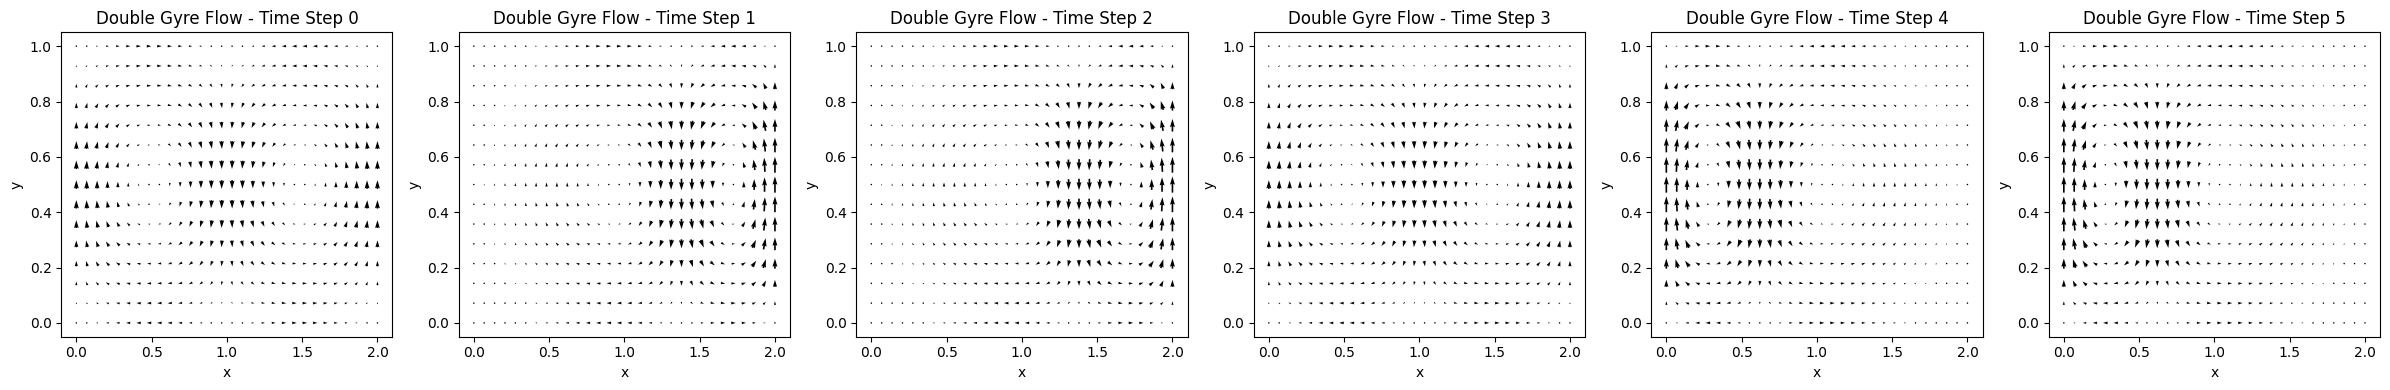

In [225]:
def generate_double_gyre_flow(n_timesteps, nx, ny,
                              A=0.1, epsilon=0.25, period=20, 
                              plot_series=False):
    """   
    The double gyre is defined on the domain x ∈ [0,2] and y ∈ [0,1]. Its velocity field is given by:
    
        f(x,t) = ε sin(ω t) x² + (1 - 2ε sin(ω t)) x
        u(x,y,t) = -π A sin(π f(x,t)) cos(π y)
        v(x,y,t) =  π A cos(π f(x,t)) sin(π y) [2ε sin(ω t) x + (1 - 2ε sin(ω t))]
    
    Parameters:
      n_timesteps : Number of timesteps.
      nx, ny : Number of spatial grid points in x and y directions.
      A : Amplitude of the velocity.
      epsilon : Strength of the time-periodic oscillation.
      period : Number of intervals for flow to repeat
      plot_series 
    
    Returns:
       u_field, v_field 
    """
    omega = 2*np.pi / period

    data    = np.zeros((n_timesteps, nx, ny))
    u_field = np.zeros((n_timesteps, nx, ny))
    v_field = np.zeros((n_timesteps, nx, ny))

    lx, ly= 2, 1 # domain is fixed 
    x = np.linspace(0, lx, nx)
    y = np.linspace(0, ly, ny)

    Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')
    
    for t in range(n_timesteps):
        # Time variable (assuming unit time steps)
        time = t
        sin_omega_t = np.sin(omega * time)
        
        # Define the function f(x,t) and its derivative with respect to x:
        # f(x,t) = ε sin(ω t) x² + (1 - 2ε sin(ω t)) x
        f = epsilon * sin_omega_t * Xgrid**2 + (1 - 2*epsilon*sin_omega_t) * Xgrid
        dfdx = 2 * epsilon * sin_omega_t * Xgrid + (1 - 2*epsilon*sin_omega_t)
        
        # Compute velocity components
        u = - np.pi * A * np.sin(np.pi * f) * np.cos(np.pi * Ygrid)
        v =   np.pi * A * np.cos(np.pi * f) * np.sin(np.pi * Ygrid) * dfdx
        
        u_field[t] = u
        v_field[t] = v
        data[t] = np.sqrt(u**2 + v**2)
    
    if plot_series:
        fig, axes = plt.subplots(1, n_timesteps, figsize=(4 * n_timesteps, 4))
        for t in range(0, n_timesteps, 1):
            ax = axes[t]
            
            # Plot magnitute
            # im = ax.imshow(data[t].T, origin='lower', extent=[0,lx,0,ly], cmap='viridis')
            # plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            # Plot direction
            ax.quiver(Xgrid, Ygrid, u_field[t], v_field[t], color='black', 
                       scale_units='xy', scale=10, width=0.005, pivot='mid')
            
            ax.set_title(f"Double Gyre Flow - Time Step {t}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
        
        plt.tight_layout()
        plt.show()
    
    return u_field, v_field


# Generate the double gyre flow data over 50 timesteps on a 100x50 grid.
_ = generate_double_gyre_flow(
    n_timesteps=6, nx=30, ny=15,
    A=0.1, epsilon=0.5, 
    period=6,
    plot_series=True
)


# Data Transformation

In [226]:
def rotate_data_90(data):
    """
    Rotate each snapshot by 90 degrees counterclockwise.
    
    Parameters
    ----------
    data : np.ndarray of shape (n_timesteps, nx, ny)
    """
    # We'll collect each rotated snapshot, then stack them back into an array.
    data_rotated_list = []
    for t in range(data.shape[0]):
        # Rotate data[t] (shape (nx, ny)) by 90 deg counterclockwise
        # np.rot90() outputs shape (ny, nx)
        slice_rot = np.rot90(data[t])
        data_rotated_list.append(slice_rot)
    
    # Stack them along the time dimension again
    data_rotated = np.stack(data_rotated_list, axis=0)
    return data_rotated


In [227]:
def reflect_data_y(data):
    """
    Reflect each snapshot about the horizontal midline in y (about y = L_y/2).
    
    Parameters
    ----------
    data : np.ndarray of shape (n_timesteps, nx, ny)
    """
    data_reflected = data[..., ::-1]
    return data_reflected

Original Data:
[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]
  [10 11 12]]]

Reflected Data (about y-mid domain):
[[[ 3  2  1]
  [ 6  5  4]
  [ 9  8  7]
  [12 11 10]]]

Rotated Data (90° counterclockwise):
[[[ 3  6  9 12]
  [ 2  5  8 11]
  [ 1  4  7 10]]]


array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]])

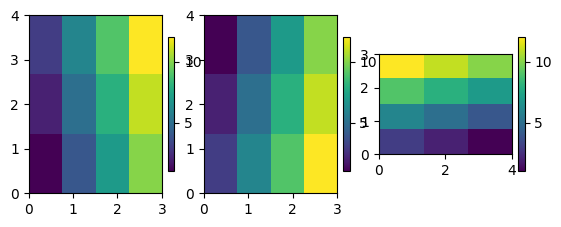

In [228]:
# Test/visulaization 
data = np.array([[
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [10, 11, 12]
]])

print("Original Data:")
print(data)

data_reflected = reflect_data_y(data)
print("\nReflected Data (about y-mid domain):")
print(data_reflected)

data_rotated = rotate_data_90(data)
print("\nRotated Data (90° counterclockwise):")
print(data_rotated)

fig, axes = plt.subplots(1, 3)
im = axes[0].imshow(data.T, origin='lower', extent=[0, 3, 0, 4], cmap='viridis')
plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
im = axes[1].imshow(data_reflected.T, origin='lower', extent=[0, 3, 0, 4], cmap='viridis')
plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
im = axes[2].imshow(data_rotated.T, origin='lower', extent=[0, 4, 0, 3], cmap='viridis')
plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

data.reshape(1, 4 * 3)

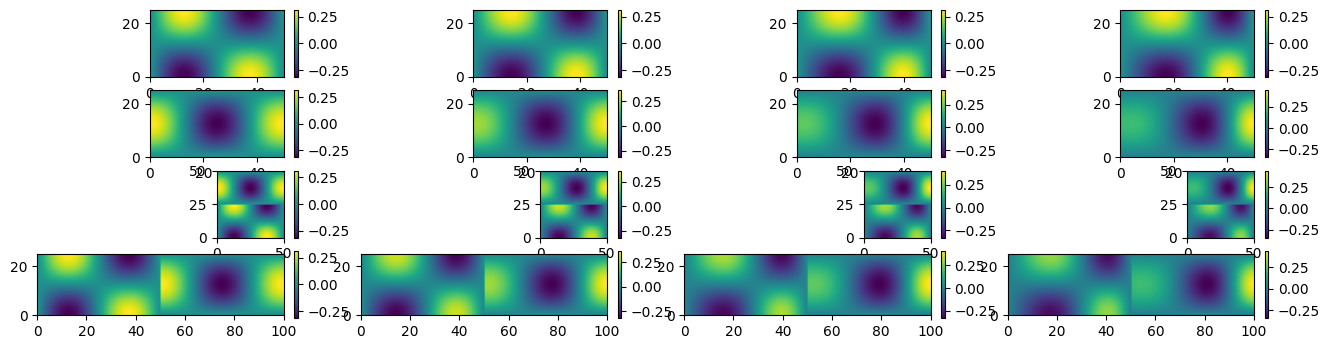

In [229]:
def combine_vector_fields(u_field, v_field, horizontal_concat=True):
    """
    Combine two vector fields (u and v) into a single augmented snapshot.
    
    Parameters:
      u_field : np.ndarray, shape (n_timesteps, nx, ny)
      v_field : np.ndarray, shape (n_timesteps, nx, ny)
      horizontal_concat : bool, optional
             True will concatenate side by side (axis=2),
             resulting in shape (n_timesteps, nx, 2*ny).
             False will concatenate top-to-bottom (axis=1),
             resulting in shape (n_timesteps, 2*nx, ny).
    """
    if horizontal_concat:
        combined_field = np.concatenate((u_field, v_field), axis=2)
    else:
        combined_field = np.concatenate((u_field, v_field), axis=1)
    
    return combined_field


n_timesteps = 4
nx, ny= 50, 25
u_field, v_field = generate_double_gyre_flow(
    n_timesteps=n_timesteps, nx=nx, ny=ny
)

combined_field_h = combine_vector_fields(u_field, v_field)
combined_field_v = combine_vector_fields(u_field, v_field, horizontal_concat=False)


fig, axes = plt.subplots(4, n_timesteps, figsize=(4 * n_timesteps, 4))
for t in range(0, n_timesteps, 1):
    for i, data in enumerate([u_field, v_field, combined_field_h, combined_field_v]):
        ax = axes[i, t]
        # Plot magnitute
        _, t_nx, t_ny = data.shape
        im = ax.imshow(data[t].T, origin='lower', extent=[0, t_nx, 0, t_ny], cmap='viridis')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


In [230]:
def map_sensor_to_original(sensor_coords, combined_shape, horizontal_concat=True):
    """
    Map sensor coordinates from a combined (augmented) domain back to the original domain.
    
    Parameters:
      sensor_coords : Each row is a coordinate [i, j] in the combined domain.
      combined_shape : The shape (n_rows, n_cols) of the combined data.
          For horizontal concatenation, this should be (nx, 2*ny_orig).
          For vertical concatenation, this should be (2*nx_orig, ny).
      mode : 'horizontal' or 'vertical'. Default is 'horizontal'.
    
    Returns:
      mapped_coords : The sensor coordinates mapped back to the original grid.
          
    Explanation:
      - In horizontal mode, if a sensor’s column index j is ≥ ny_orig,
        then its original column index is j - ny_orig (while the row index stays the same).
      - In vertical mode, if a sensor’s row index i is ≥ nx_orig,
        then its original row index is i - nx_orig (while the column index stays the same).
    """
    mapped_coords = sensor_coords.copy() 
    
    if horizontal_concat:
        # combined_shape[1] is 2 * ny_orig.
        ny_combined = combined_shape[1]
        ny_orig = ny_combined // 2
        for idx, (i, j) in enumerate(sensor_coords):
            if j >= ny_orig:
                mapped_coords[idx, 1] = j - ny_orig
            # else: keep the same
    else:
        # combined_shape[0] is 2 * nx_orig.
        nx_combined = combined_shape[0]
        nx_orig = nx_combined // 2
        for idx, (i, j) in enumerate(sensor_coords):
            if i >= nx_orig:
                mapped_coords[idx, 0] = i - nx_orig
    
    return mapped_coords

In [231]:
def to_complex_cartesian(u, v):
    return u + 1j * v

In [232]:
def to_complex_polar(u, v):
    r = np.sqrt(u**2 + v**2)
    theta = np.arctan2(v, u)
    return r * np.exp(1j * theta)

# Sensor Placement

In [233]:
def plot_optimal_sensors(nx, ny,
                         data_interval, sensor_coords, 
                         ax, plot_title, plot='imshow'):
    if plot == 'imshow':
        # For visualization, use mean
        avg_field = data_interval.mean(axis=0)
        im = ax.imshow(avg_field.T, origin='lower', extent=[0, nx, 0, ny], cmap='viridis')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    elif plot == 'quiver':
        u_field, v_field = data_interval
        x = np.linspace(0, 1, nx)
        y = np.linspace(0, 2, ny)
        # Use 'ij' indexing: first index corresponds to x, second to y.
        Xgrid, Ygrid = np.meshgrid(x, y, indexing='ij')
        ax.quiver(Xgrid, Ygrid, u_field[t], v_field[t], color='black', 
                       scale_units='xy', scale=10, width=0.005, pivot='mid')


    sensor_x = sensor_coords[:, 0]
    sensor_y = sensor_coords[:, 1]

    ax.scatter(sensor_x, sensor_y, 
                color='red', marker='o', s=50)
    ax.set_title(plot_title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

In [234]:
def get_sspor_sensors(X, n_sensors, n_basis_modes):
    """
    Given a batch of fluid flow data for a time interval, 
    use PySensors to find optimal sensor locations.
    
    Parameters:
        data_interval : (n_timesteps, nx, ny) for the interval.
        n_sensors : number of sensors to select.
    
    Returns:
        sensor_coords
    """
    # axis=0: means do it col-wise (grid-point-wise); axis=1: means do it row-wise (time-step-wise)
    X = X - X.mean(axis=0)
    # X = X - X.mean(axis=1, keepdims=True) # center the data

    # std_loc = X.std(axis=0, keepdims=True)
    # X = X / std_loc

    # std_time = X.std(axis=1, keepdims=True)
    # X = X / std_time
    
    basis = ps.basis.SVD(n_basis_modes=n_basis_modes, algorithm='arpack', random_state=90)
    model = ps.SSPOR(n_sensors=n_sensors, basis=basis)
    model.fit(X)

    # Test the reconstruction error on the same data X.
    error = model.reconstruction_error(X, sensor_range=[n_sensors])
    print("Reconstruction error (RMSE):", error)
    
    sensor_indices = model.selected_sensors
    return sensor_indices


In [ ]:
# Generate data
n_timesteps = 120      # Total number of timesteps in the dataset
n_sensors = 15         # Number of sensors to select in each interval
interval_length = 30   # Number of timesteps per batch
n_basis_modes = 15     # Number of modes in data

nx, ny = 30, 15 # number of grid points along each axis
u_field, v_field = generate_double_gyre_flow(
    n_timesteps=n_timesteps, nx=nx, ny=ny,
    A=0.1, epsilon=0.5, period=300
)

# nx, ny = 25, 25 # number of grid points along each axis
# u_field, v_field = generate_moving_vortex(n_timesteps, nx, ny)

In [ ]:
# Feild concatenation 
horizontal_concat = False
magnitude = np.sqrt(v_field ** 2 + u_field ** 2)
magnitude = magnitude / magnitude.max()
angle = np.arctan2(v_field, u_field) 
angle = angle / angle.max()
data = combine_vector_fields(magnitude, angle, horizontal_concat=horizontal_concat)
_, nx_t, ny_t = data.shape # change dim to match shape of data for future plotting

In [237]:
# # Complex representation
# data = to_complex_cartesian(u_field, v_field)
# _, nx_t, ny_t = data.shape

Reconstruction error (RMSE): [1.75148626e-06]
Reconstruction error (RMSE): [1.72070701e-06]
Reconstruction error (RMSE): [1.64261002e-06]
Reconstruction error (RMSE): [1.7109943e-06]


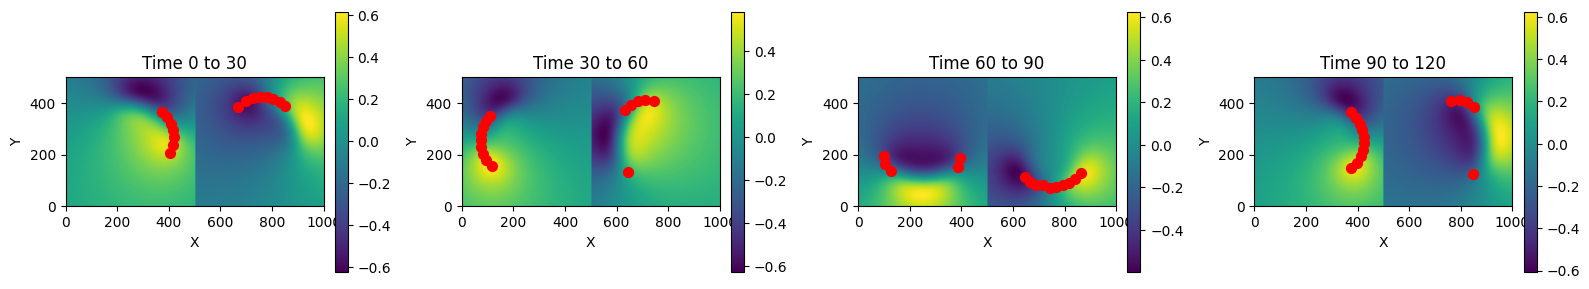

In [ ]:
intervals = range(0, n_timesteps, interval_length)
fig, axes = plt.subplots(1, len(list(intervals)), figsize=(4 * len(list(intervals)), 4))
sensor_coords_list = []

for i, start in enumerate(intervals):
    end = min(start + interval_length, n_timesteps)
    data_interval = data[start:end]

    # flattens row-wise (but rmr row is a col-strip in our 2d map), so append on the slices of y-axis together
    X = data_interval.reshape(interval_length, nx_t * ny_t)
    sensor_indices = get_sspor_sensors(X, n_sensors, n_basis_modes)
    
    # Convert the flat indices back to 2D coordinates on the nx x ny grid.
    sensor_coords = np.array(np.unravel_index(sensor_indices, (nx_t, ny_t))).T # get index in row-major form by default
    sensor_coords_list.append(sensor_coords)
    plot_optimal_sensors(nx_t, ny_t, data_interval, sensor_coords, axes[i], f"Time {start} to {end}")

    
plt.tight_layout()
plt.show()


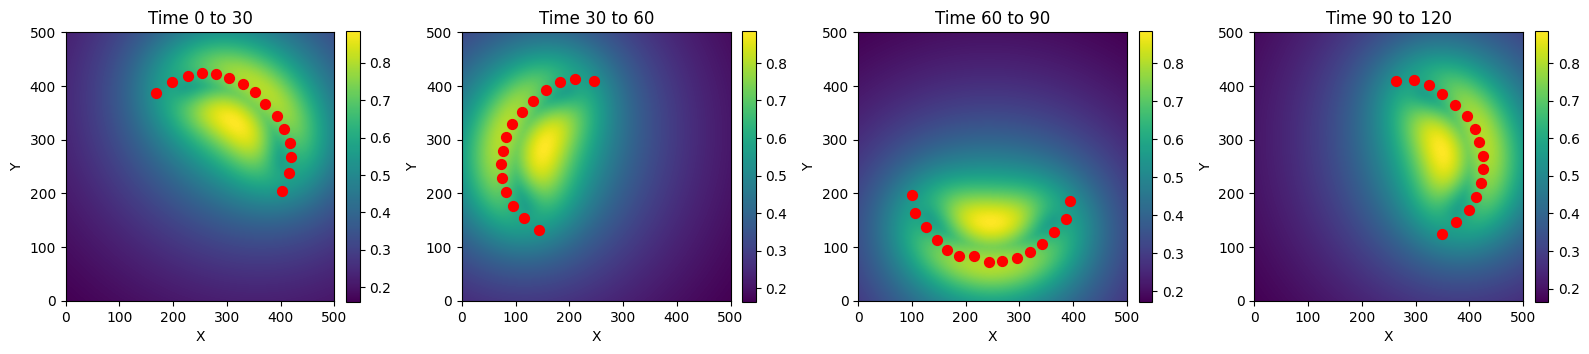

In [239]:
# Replot concatenated fields into original feild
intervals = range(0, n_timesteps, interval_length)
fig, axes = plt.subplots(1, len(list(intervals)), figsize=(4 * len(list(intervals)), 4))

for i, start in enumerate(intervals):
    end = min(start + interval_length, n_timesteps)
    plot_optimal_sensors(nx, ny, magnitude[start:end],
        map_sensor_to_original(sensor_coords_list[i], (nx_t, ny_t), horizontal_concat),
        axes[i], f"Time {start} to {end}")

    
plt.tight_layout()
plt.show()